# Model 2 - This is the model which represents the final model with hyperparameter tuning and all of the correlation heatmaps and feature importance graphs

### WARNING - please place the file in the same directory as the dataset csv file

##### importing the necessary modules

In [1]:
# necessary imports
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import time

## Importing the dataset

In [2]:
# importing data
data = pd.read_csv('Products_Information.csv')

# as the date is an 'object', changing it into datetime64(ms) format
data['date'] = pd.to_datetime(data['date'])

# setting the date as index
data.set_index('date', inplace=True)



##### Removing Outliers

In [3]:
data = data[data['sales'] <= 40000]

##### extracting date features from date index

In [4]:
# breaking the date into day_of_week, month and day_of_month
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_month'] = data.index.day


In [5]:
# storing our data into a new variable 
data_encoded = data.copy(deep=True)

##### Lagged Feature and Rolling Windows

In [6]:
# lagged feature capturing the sales data of the previous week's same day
data_encoded['sales_lag_7'] = data_encoded.groupby(['store_nbr', 'product_type'])['sales'].shift(7)

# rolling windows 
data_encoded['rolling_window_7_skew'] = data_encoded.groupby(['store_nbr', 'product_type'])['sales'].shift(1).rolling(window=7).skew()

data_encoded['rolling_window_7_std'] = data_encoded.groupby(['store_nbr', 'product_type'])['sales'].shift(1).rolling(window=7).std()


## Label Encoding product_type

In [7]:
label_encoder = LabelEncoder()

data_encoded['product_type'] = label_encoder.fit_transform(data['product_type'])

# removing the id column for preparation of training and prediction datasets


In [8]:
data_encoded = data_encoded.drop('id',axis = 1)

## splitting the data

In [9]:
# splitting the dataset into training and predictions

training_data = data_encoded['2016-01-01':'2017-07-30']

prediction_data = data_encoded['2017-07-31':'2017-08-15']


In [10]:
# Splitting the training data into input and output arrays
X = training_data.drop(['sales'], axis=1)
y = training_data['sales']

# Implementing Time Series Split with 3 splits
tscv = TimeSeriesSplit(n_splits=3)  

# Defining the parameter grid for randomized search
param_grid = {
    'max_iter': list(range(100, 700, 100)),  # The maximum number of iterations of the boosting process.
    'max_leaf_nodes': list(range(15, 60, 10)),  # The maximum number of leaves for each tree.
    'max_depth': list(range(1, 10,3)),  # The maximum depth of each tree.
    'min_samples_leaf': list(range(20, 60, 10)),  # The minimum number of samples per leaf.
    'learning_rate': [0.1, 0.01, 0.001],  # The learning rate, also known as shrinkage.
    'l2_regularization': [0.0, 0.1, 0.01, 0.001]  # The L2 regularization parameter.
}

# Creating HGBR Model 2 (best performing model)
model = HistGradientBoostingRegressor(random_state=20, categorical_features = ['day_of_week', 'month', 'day_of_month','store_nbr', 'product_type'])

# Creating RandomizedSearch CV grid
random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=10, scoring='neg_root_mean_squared_error',random_state=20,cv=tscv, n_jobs=-1
)

# Create a list to score the scores for each fold
rmse_scores = []

# Measuring run time for Cross Validation
start_time = time.time()

# Performing RandomizedSearchCV using Time Series split to separate training and validation sets.
random_search.fit(X, y)

# Storing the best model from randomized search CV
best_model = random_search.best_estimator_


# Print the run time for randomized search CV
elapsed_time = time.time() - start_time
print(f"Randomized Search took {elapsed_time:.2f} seconds.")
print("\n")

# Print the best hyperparameters from the randomized search
print("Best Hyperparameters:", random_search.best_params_)



# Printing the performance of the best model on each TimeSeriesSplit to measure performance across folds
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    predictions = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    rmse_scores.append(rmse)

    print(f"RMSE for this fold: {rmse}")

Randomized Search took 47.04 seconds.


Best Hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 35, 'max_iter': 600, 'max_depth': 7, 'learning_rate': 0.1, 'l2_regularization': 0.1}
RMSE for this fold: 137.01559312463607
RMSE for this fold: 177.81622848829707
RMSE for this fold: 177.49894497233535


##### PERMUTATION IMPORTANCE GRAPH ON VALIDATION SET

In [11]:
# Calculating permutation importance for the validation set
result = permutation_importance(best_model, X_test, y_test, n_repeats=3, random_state=20)

# Extracting the performance scores
importance_scores = result.importances_mean

# Printing permutation importance
print("The permutation feature importance is:")
for feature, importance in zip(X.columns, importance_scores):
    print(f"{feature}: {importance}")


The permutation feature importance is:
store_nbr: 0.0917480579584945
product_type: 0.3736110215880199
special_offer: 0.03967278023427667
day_of_week: 0.05207897013479964
month: 0.008764807363823643
day_of_month: 0.029407325770294663
sales_lag_7: 0.2752481739841795
rolling_window_7_skew: 0.014330818990078967
rolling_window_7_std: 0.0730037948826769


**PERM IMPORTANCE BAR CHART - VALIDATION SET**

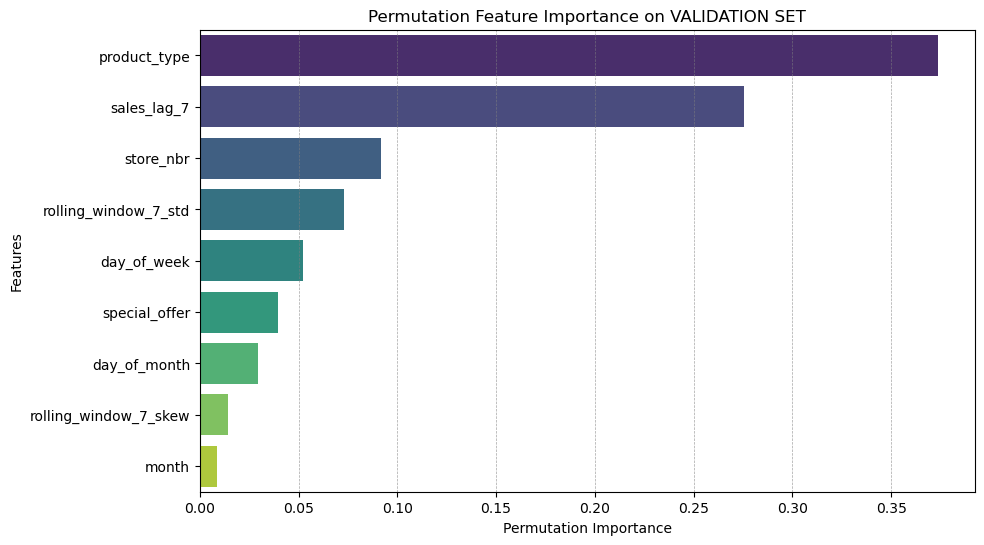

In [12]:
# Storing the permutation feature importances within a dictionary
feature_importances = {
    'store_nbr': 0.0917480579584945,
    'product_type': 0.3736110215880199,
    'special_offer': 0.03967278023427667,
    'day_of_week': 0.05207897013479964,
    'month': 0.008764807363823643,
    'day_of_month': 0.029407325770294663,
    'sales_lag_7': 0.2752481739841795,
    'rolling_window_7_skew': 0.014330818990078967,
    'rolling_window_7_std': 0.0730037948826769
}

# sorting the feature importances by descending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# converting the permutation importances into a dataframe to make plotting easier
perm_imports = pd.DataFrame(sorted_feature_importances.items(), columns=['Feature', 'Permutation Importance'])

# generating a bar plot of permutation featute importance
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_imports, x='Permutation Importance', y='Feature', palette='viridis')
plt.title('Permutation Feature Importance on VALIDATION SET')
plt.ylabel('Features')
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', axis='x', alpha=0.7, zorder=0)  
plt.show()


##### Model's Prediction on TEST SET

In [13]:
# This is to test on our Predictons Dataset

X_evaluation = prediction_data.drop(['sales'], axis = 1)
y_evaluation = prediction_data['sales'] 
y_predictions = best_model.predict(X_evaluation)

# Evaluate the models performance on the test set
mse = mean_squared_error(y_evaluation, y_predictions)
rmse = np.sqrt(mse)
print(f"RMSE for our test data: {rmse}")

RMSE for our test data: 222.04006314345023


##### PERMUTATION IMPORTANCE GRAPH ON TEST SET

In [14]:
# Calculate the permutation importance on the test set
result = permutation_importance(best_model, X_evaluation, y_evaluation, n_repeats=3, random_state=20)

# Extracting the perm importance scores
importance_scores = result.importances_mean

# Printing permutation importance
print("Permutation Feature Importance:")
for feature, importance in zip(X.columns, importance_scores):
    print(f"{feature}: {importance}")


Permutation Feature Importance:
store_nbr: 0.09274426813362424
product_type: 0.42435579578350796
special_offer: 0.032773806741835866
day_of_week: 0.023300998223528713
month: 0.00106120267963646
day_of_month: 0.01813323694425913
sales_lag_7: 0.23785484056436076
rolling_window_7_skew: 0.013810282895015883
rolling_window_7_std: 0.05782082065698054


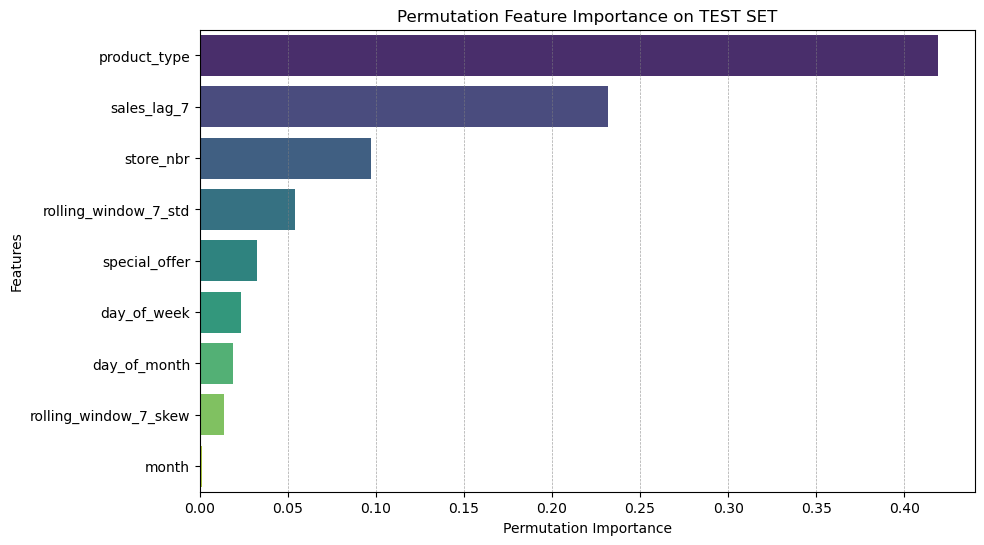

In [15]:
# Storing Permutation Feature Importance values into a dictionary for plotting

feature_importances = {
    'store_nbr': 0.09746374064109886,
    'product_type': 0.41906531450516643,
    'special_offer': 0.03261260570285333,
    'day_of_week': 0.02329577930919176,
    'month': 0.0011013865401231875,
    'day_of_month': 0.018965447799829522,
    'sales_lag_7': 0.23173005097303942,
    'rolling_window_7_skew': 0.013529282729887107,
    'rolling_window_7_std': 0.05402526369871419
}

# sorting the feature importances by descending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# converting the permutation importances into a dataframe to make plotting easier
perm_imports = pd.DataFrame(sorted_feature_importances.items(), columns=['Feature', 'Permutation Importance'])

# generating a bar plot of permutation featute importance
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_imports, x='Permutation Importance', y='Feature', palette='viridis')
plt.title('Permutation Feature Importance on TEST SET')
plt.ylabel('Features')
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', axis='x', alpha=0.7, zorder=0)  
plt.show()


# END OF FILE